In [67]:
romania = {
 'A': ['Z', 'T', 'S'],
 'B': ['F', 'P', 'G', 'U'],
 'C': ['D', 'R', 'P'],
 'D': ['M', 'C'],
 'E': ['H'],
 'F': ['S', 'B'],
 'G': ['B'],
 'H': ['U', 'E'],
 'I': ['N', 'V'],
 'L': ['T', 'M'],
 'M': ['L', 'D'],
 'N': ['I'],
 'O': ['Z', 'S'],
 'P': ['R', 'C', 'B'],
 'R': ['S', 'C', 'P'],
 'S': ['A', 'O', 'F', 'R'],
 'T': ['A', 'L'],
 'U': ['B', 'V', 'H'],
 'V': ['U', 'I'],
 'Z': ['O', 'A']}

In [68]:
from collections import deque

def breadth_first(start, goal, neighbors):
    frontier = deque([start])
    previous = {start:None}
    if goal == start:
        return [start]
    while frontier:
        s = frontier.popleft()
        if s == goal:
            return path(previous,s)
        for s2 in neighbors[s]:
            if s2 not in previous:
                previous[s2] = s
                frontier.append(s2)
def path(previous, s):
    return [] if s== None else path(previous,previous[s])+ [s]
breadth_first('L', 'N', romania)

['L', 'T', 'A', 'S', 'F', 'B', 'U', 'V', 'I', 'N']

In [69]:
from search import *
sgb_words = open_data("EN-text/sgb-words.txt")

In [70]:
WORDS = set(sgb_words.read().split())
len(WORDS)

5757

In [71]:
def neighboring_words(word):
    neighbor = {word[:i] + c + word[i+1:] for i \
                in range(len(word)) for c in 'abcdefghijklmnopqrstuvwxyz'
               if c!=word[i]}
    return neighbor & WORDS

In [72]:
neighboring_words('cello')

{'cells', 'hello', 'jello'}

In [73]:
word_neighbors = {word: neighboring_words(word) for word in WORDS}

In [74]:
breadth_first('green', 'grass', word_neighbors)

['green', 'greed', 'treed', 'trees', 'treys', 'greys', 'grays', 'grass']

In [75]:
def breadth_first_search(problem):
    "Search for goal; paths with least number of steps first."
    if problem.is_goal(problem.initial): 
        return Node(problem.initial)
    frontier = FrontierQ(Node(problem.initial), LIFO=False)
    explored = set()
    while frontier:
        node = frontier.pop()
        explored.add(node.state)
        for action in problem.actions(node.state):
            child = node.child(problem, action)
            if child.state not in explored and child.state not in frontier:
                if problem.is_goal(child.state):
                    return child
                frontier.add(child)

In [76]:
def uniform_cost_search(problem, costfn=lambda node: node.path_cost):
    frontier = FrontierPQ(Node(problem.initial), costfn)
    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        explored.add(node.state)
        for action in problem.actions(node.state):
            child = node.child(problem, action)
            if child.state not in explored and child not in frontier:
                frontier.add(child)
            elif child in frontier and frontier.cost[child] < child.path_cost:
                frontier.replace(child)

def astar_search(problem,heuristic):
    costfn = lambda node: node.path_cost + heuristic(node.state)
    return uniform_cost_search(problem,costfn)

**Node** is the search tree. Keep calling  _node.previous_  and appending each node until it reaches None will return path.

Searching seeks to address a specific **Problem**. Thus Problem implements is_goal and results. Result is the new state after performing an action.

**Action** is a list of action each agent can take. 
```
for action in problem.actions(node.state) == for child in self.neighbors[s]
```
problem.actions is a list of actions executable in current state, aka, current node.
Node is a wrapper that encodes the state, thus child node is created when a state is a result of the current state.

In [77]:
class Node(object):
    """A node in a search tree. A search tree is spanning tree over states.
    A Node contains a state, the previous node in the tree, the action that
    takes us from the previous state to this state, and the path cost to get to 
    this state. If a state is arrived at by two paths, then there are two nodes 
    with the same state."""

    def __init__(self, state, previous=None, action=None, step_cost=1):
        "Create a search tree Node, derived from a previous Node by an action."
        self.state     = state
        self.previous  = previous
        self.action    = action
        self.path_cost = 0 if previous is None else (previous.path_cost + step_cost)

    def __repr__(self): return "<Node {}: {}>".format(self.state, self.path_cost)
    
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    def child(self, problem, action):
        "The Node you get by taking an action from this Node."
        #result returns a new state
        result = problem.result(self.state, action)
       #Node(state,previous=self,action,cost)
        return Node(result, self, action, 
                    problem.step_cost(self.state, action, result))



In [78]:
from collections import OrderedDict
import heapq



class FrontierQ(OrderedDict):
    "A Frontier that supports FIFO or LIFO Queue ordering."
    
    def __init__(self, initial, LIFO=False):
        """Initialize Frontier with an initial Node.
        If LIFO is True, pop from the end first; otherwise from front first."""
        super(FrontierQ, self).__init__()
        self.LIFO = LIFO
        self.add(initial)
    
    def add(self, node):
        "Add a node to the frontier."
        self[node.state] = node
        
    def pop(self):
        "Remove and return the next Node in the frontier."
        (state, node) = self.popitem(self.LIFO)
        return node
    
    def replace(self, node):
        "Make this node replace the nold node with the same state."
        del self[node.state]
        self.add(node)
class FrontierPQ:
    "A Frontier ordered by a cost function; a Priority Queue."
    
    def __init__(self, initial, costfn=lambda node: node.path_cost):
        "Initialize Frontier with an initial Node, and specify a cost function."
        self.heap   = []
        self.states = {}
        self.costfn = costfn
        self.add(initial)
    
    def add(self, node):
        "Add node to the frontier."
        cost = self.costfn(node)
        heapq.heappush(self.heap, (cost, node))
        self.states[node.state] = node
        
    def pop(self):
        "Remove and return the Node with minimum cost."
        (cost, node) = heapq.heappop(self.heap)
        self.states.pop(node.state, None) # remove state
        return node
    
    def replace(self, node):
        "Make this node replace a previous node with the same state."
        if node.state not in self:
            raise ValueError('{} not there to replace'.format(node.state))
        for (i, (cost, old_node)) in enumerate(self.heap):
            if old_node.state == node.state:
                self.heap[i] = (self.costfn(node), node)
                heapq._siftdown(self.heap, 0, i)
                return

    def __contains__(self, state): return state in self.states
    
    def __len__(self): return len(self.heap)

In [79]:

def action_sequence(node):
    "The sequence of actions to get to this node."
    actions = []
    while node.previous:
        actions.append(node.action)
        node = node.previous
    return actions[::-1]

def state_sequence(node):
    "The sequence of states to get to this node."
    states = [node.state]
    while node.previous:
        node = node.previous
        states.append(node.state)
    return states[::-1]

In [80]:
class Problem:
    def __init__(self, initial= None, goals= (), **additional_keywords):
        self.initial = initial  # The initial state of the problem.
        self.goals = goals      # A collection of possible goal states.
        self.__dict__.update(**additional_keywords)

    def actions(self, state):
        "Return a list of actions executable in this state."
        raise NotImplementedError # Override this!

    def result(self, state, action):
        "The state that results from executing this action in this state."
        raise NotImplementedError # Override this!

    def is_goal(self, state):
        "True if the state is a goal." 
        return state in self.goals # Optionally override this!

    def step_cost(self, state, action, result=None):
        "The cost of taking this action from this state."
        return 1 # Override this if actions have different costs

In [81]:
dirt = '*'
clean = ' '
class TwoLocatonVacuumProblem(Problem):
    def actions(self, state):
        return ('W', 'E', 'Suck')
    
    def is_goal(self, state):
        return dirt not in state
    
    def result(self, state, action):
        (loc, dirtW, dirtE) = state
        if action == 'W': return ('W',dirtW,dirtE)
        elif action == 'E': return ('E',dirtW,dirtE)
        elif action == 'Suck' and loc == 'W': return (loc, clean,dirtE)
        elif action == 'Suck' and loc == 'E': return (loc, dirtW, clean)
        else: raise ValueError('unknown error' + action)

In [82]:
class PourProblem(Problem):
    """Problem about pouring water between jugs to achieve some water level.
    Each state is a tuples of levels. In the initialization, provide a tuple of 
    capacities, e.g. PourProblem(capacities=(8, 16, 32), initial=(2, 4, 3), goals={7}), 
    which means three jugs of capacity 8, 16, 32, currently filled with 2, 4, 3 units of 
    water, respectively, and the goal is to get a level of 7 in any one of the jugs."""
    
    def actions(self, state):
        """The actions executable in this state."""
        jugs = range(len(state))
        return ([('Fill', i)    for i in jugs if state[i] != self.capacities[i]] +
                [('Dump', i)    for i in jugs if state[i] != 0] +
                [('Pour', i, j) for i in jugs for j in jugs if i != j])

    def result(self, state, action):
        """The state that results from executing this action in this state."""
        result = list(state)
        act, i, j = action[0], action[1], action[-1]
        if act == 'Fill': # Fill i to capacity
            result[i] = self.capacities[i]
        elif act == 'Dump': # Empty i
            result[i] = 0
        elif act == 'Pour':
            a, b = state[i], state[j]
            result[i], result[j] = ((0, a + b) 
                                    if (a + b <= self.capacities[j]) else
                                    (a + b - self.capacities[j], self.capacities[j]))
        else:
            raise ValueError('unknown action', action)
        return tuple(result)

    def is_goal(self, state):
        """True if any of the jugs has a level equal to one of the goal levels."""
        return any(level in self.goals for level in state)

In [83]:
p7 = PourProblem(initial=(2, 0), capacities=(5, 13), goals={7})
p7.result((2, 0),  ('Fill', 1))

(2, 13)

In [84]:
result = uniform_cost_search(p7)

In [85]:
action_sequence(result)

[('Pour', 0, 1), ('Fill', 0), ('Pour', 0, 1)]

In [86]:
def showpath(searcher, problem):
    "Show what happens when searcvher solves problem."
    problem = Instrumented(problem)
    print('\n{}:'.format(searcher.__name__))
    result = searcher(problem)
    if result:
        actions = action_sequence(result)
        state = problem.initial
        path_cost = 0
        for steps, action in enumerate(actions, 1):
            path_cost += problem.step_cost(state, action, 0)
            result = problem.result(state, action)
            print('  {} =={}==> {}; cost {} after {} steps'
                  .format(state, action, result, path_cost, steps,
                          '; GOAL!' if problem.is_goal(result) else ''))
            state = result
    msg = 'GOAL FOUND' if result else 'no solution'
    print('{} after {} results and {} goal checks'
          .format(msg, problem._counter['result'], problem._counter['is_goal']))
        
from collections import Counter

class Instrumented:
    "Instrument an object to count all the attribute accesses in _counter."
    def __init__(self, obj):
        self._object = obj
        self._counter = Counter()
    def __getattr__(self, attr):
        self._counter[attr] += 1
        return getattr(self._object, attr)

In [87]:
showpath(uniform_cost_search, p7)


uniform_cost_search:
  (2, 0) ==('Pour', 0, 1)==> (0, 2); cost 1 after 1 steps
  (0, 2) ==('Fill', 0)==> (5, 2); cost 2 after 2 steps
  (5, 2) ==('Pour', 0, 1)==> (0, 7); cost 3 after 3 steps
GOAL FOUND after 83 results and 22 goal checks


In [88]:
class GreenPourProblem(PourProblem):    
    def step_cost(self, state, action, result=None):
        "The cost is the amount of water used in a fill."
        if action[0] == 'Fill':
            i = action[1]
            return self.capacities[i] - state[i]
        return 0

In [89]:
def compare_searchers(problem, searchers=None):
    "Apply each of the search algorithms to the problem, and show results"
    if searchers is None: 
        searchers = (breadth_first_search, uniform_cost_search)
    for searcher in searchers:
        showpath(searcher, problem)

In [90]:
p = GreenPourProblem(initial=(0, 0), capacities=(7, 13), goals={2})
showpath(uniform_cost_search, p)


uniform_cost_search:
  (0, 0) ==('Fill', 0)==> (7, 0); cost 7 after 1 steps
  (7, 0) ==('Pour', 0, 1)==> (0, 7); cost 7 after 2 steps
  (0, 7) ==('Fill', 0)==> (7, 7); cost 14 after 3 steps
  (7, 7) ==('Pour', 0, 1)==> (1, 13); cost 14 after 4 steps
  (1, 13) ==('Dump', 1)==> (1, 0); cost 14 after 5 steps
  (1, 0) ==('Pour', 0, 1)==> (0, 1); cost 14 after 6 steps
  (0, 1) ==('Fill', 0)==> (7, 1); cost 21 after 7 steps
  (7, 1) ==('Pour', 0, 1)==> (0, 8); cost 21 after 8 steps
  (0, 8) ==('Fill', 0)==> (7, 8); cost 28 after 9 steps
  (7, 8) ==('Pour', 0, 1)==> (2, 13); cost 28 after 10 steps
GOAL FOUND after 184 results and 48 goal checks


In [91]:
def compare_searchers(problem, searchers=None):
    "Apply each of the search algorithms to the problem, and show results"
    if searchers is None: 
        searchers = (breadth_first_search, uniform_cost_search)
    for searcher in searchers:
        showpath(searcher, problem)

In [92]:
compare_searchers(p)


breadth_first_search:
  (0, 0) ==('Fill', 0)==> (7, 0); cost 7 after 1 steps
  (7, 0) ==('Pour', 0, 1)==> (0, 7); cost 7 after 2 steps
  (0, 7) ==('Fill', 0)==> (7, 7); cost 14 after 3 steps
  (7, 7) ==('Pour', 0, 1)==> (1, 13); cost 14 after 4 steps
  (1, 13) ==('Dump', 1)==> (1, 0); cost 14 after 5 steps
  (1, 0) ==('Pour', 0, 1)==> (0, 1); cost 14 after 6 steps
  (0, 1) ==('Fill', 0)==> (7, 1); cost 21 after 7 steps
  (7, 1) ==('Pour', 0, 1)==> (0, 8); cost 21 after 8 steps
  (0, 8) ==('Fill', 0)==> (7, 8); cost 28 after 9 steps
  (7, 8) ==('Pour', 0, 1)==> (2, 13); cost 28 after 10 steps
GOAL FOUND after 100 results and 31 goal checks

uniform_cost_search:
  (0, 0) ==('Fill', 0)==> (7, 0); cost 7 after 1 steps
  (7, 0) ==('Pour', 0, 1)==> (0, 7); cost 7 after 2 steps
  (0, 7) ==('Fill', 0)==> (7, 7); cost 14 after 3 steps
  (7, 7) ==('Pour', 0, 1)==> (1, 13); cost 14 after 4 steps
  (1, 13) ==('Dump', 1)==> (1, 0); cost 14 after 5 steps
  (1, 0) ==('Pour', 0, 1)==> (0, 1); cost 14

In [93]:
import random
N,S,E,W = DIRECTIONS = [(0,1), (0,-1),(1,0), (-1,0)]
def Grid(width, height, obstacles=0.1):
    """!!!!grid is set"""
    grid = {(x,y) for x in range(width) for y in range(height)}
    if isinstance(obstacles,(float,int)):
        obstacles = random.sample(grid,int(width*height*obstacles))
    def neighbors(x, y):
        for (dx, dy) in DIRECTIONS:
            (nx, ny) = (x + dx, y + dy)
            if (nx,ny) not in obstacles and 0 <= nx < width and 0 <= ny < height:
                yield (nx, ny)

    return {(x, y): list(neighbors(x,y)) for x in range(width) for y in range(height)}
Grid(5,5)
    

{(0, 0): [(0, 1), (1, 0)],
 (0, 1): [(0, 2), (0, 0)],
 (0, 2): [(0, 3), (0, 1), (1, 2)],
 (0, 3): [(0, 4), (0, 2), (1, 3)],
 (0, 4): [(0, 3), (1, 4)],
 (1, 0): [(2, 0), (0, 0)],
 (1, 1): [(1, 2), (1, 0), (2, 1), (0, 1)],
 (1, 2): [(1, 3), (2, 2), (0, 2)],
 (1, 3): [(1, 4), (1, 2), (0, 3)],
 (1, 4): [(1, 3), (2, 4), (0, 4)],
 (2, 0): [(2, 1), (3, 0), (1, 0)],
 (2, 1): [(2, 2), (2, 0), (3, 1)],
 (2, 2): [(2, 1), (3, 2), (1, 2)],
 (2, 3): [(2, 4), (2, 2), (3, 3), (1, 3)],
 (2, 4): [(3, 4), (1, 4)],
 (3, 0): [(3, 1), (4, 0), (2, 0)],
 (3, 1): [(3, 2), (3, 0), (4, 1), (2, 1)],
 (3, 2): [(3, 3), (3, 1), (4, 2), (2, 2)],
 (3, 3): [(3, 4), (3, 2), (4, 3)],
 (3, 4): [(3, 3), (4, 4), (2, 4)],
 (4, 0): [(4, 1), (3, 0)],
 (4, 1): [(4, 2), (4, 0), (3, 1)],
 (4, 2): [(4, 3), (4, 1), (3, 2)],
 (4, 3): [(4, 4), (4, 2), (3, 3)],
 (4, 4): [(4, 3), (3, 4)]}

In [94]:
class GridProblem(Problem):
    def actions(self, state):
        return DIRECTIONS
    def result(self,state,action ):
        x, y = state
        dx, dy = action
        return (x+dx, y+dy) if (x+dx, y+dy) in self.grid[state] else state 
gp = GridProblem(grid = Grid(5,5,0.3),initial=(0,0),goals={(4,4)})
showpath(uniform_cost_search,gp )


uniform_cost_search:
no solution after 92 results and 23 goal checks


In [95]:
def hardness(problem):
    L = breadth_first_search(problem)
    return len(action_sequence(L)) if L is not None else 0 
hardness(p7)

3

In [96]:
class TSP_problem(Problem):

    '''
    subclass of Problem to define various functions 
    '''

    def two_opt(self, state):
        '''
        Neighbour generating function for Traveling Salesman Problem
        '''
        state2 = state[:]
        l = random.randint(0, len(state2) - 1)
        r = random.randint(0, len(state2) - 1)
        if l > r:
            l, r = r,l
        state2[l : r + 1] = reversed(state2[l : r + 1])
        return state2

    def actions(self, state):
        '''
        action that can be excuted in given state
        '''
        return [self.two_opt]
    
    def result(self, state, action):
        '''
        result after applying the given action on the given state
        '''
        return action(state)

    def path_cost(self, c, state1, action, state2):
        '''
        total distance for the Traveling Salesman to be covered if in state2
        '''
        cost = 0
        for i in range(len(state2) - 1):
            cost += distances[state2[i]][state2[i + 1]]
        cost += distances[state2[0]][state2[-1]]
        return cost
 
    def value(self, state):
        '''
        value of path cost given negative for the given state
        '''
        return -1 * self.path_cost(None, None, None, state)

In [97]:
def init():
    ''' 
    Initialisation function for matplotlib animation
    '''
    line.set_data([], [])
    for name, coordinates in romania_map.locations.items():
            ax.annotate(
            name,
            xy=coordinates, xytext=(-10, 5), textcoords='offset points', size = 10)
    text.set_text("Cost = 0 i = 0" )

    return line, 

def animate(i):
    '''
    Animation function to set next path and print its cost.
    '''
    x, y = [], []
    for name in states[i]:
        x.append(romania_map.locations[name][0])
        y.append(romania_map.locations[name][1])
    x.append(romania_map.locations[states[i][0]][0])
    y.append(romania_map.locations[states[i][0]][1])
    line.set_data(x,y) 
    text.set_text("Cost = " + str('{:.2f}'.format(TSP_problem.path_cost(None, None, None, None, states[i]))))
    return line,

<IPython.core.display.Javascript object>


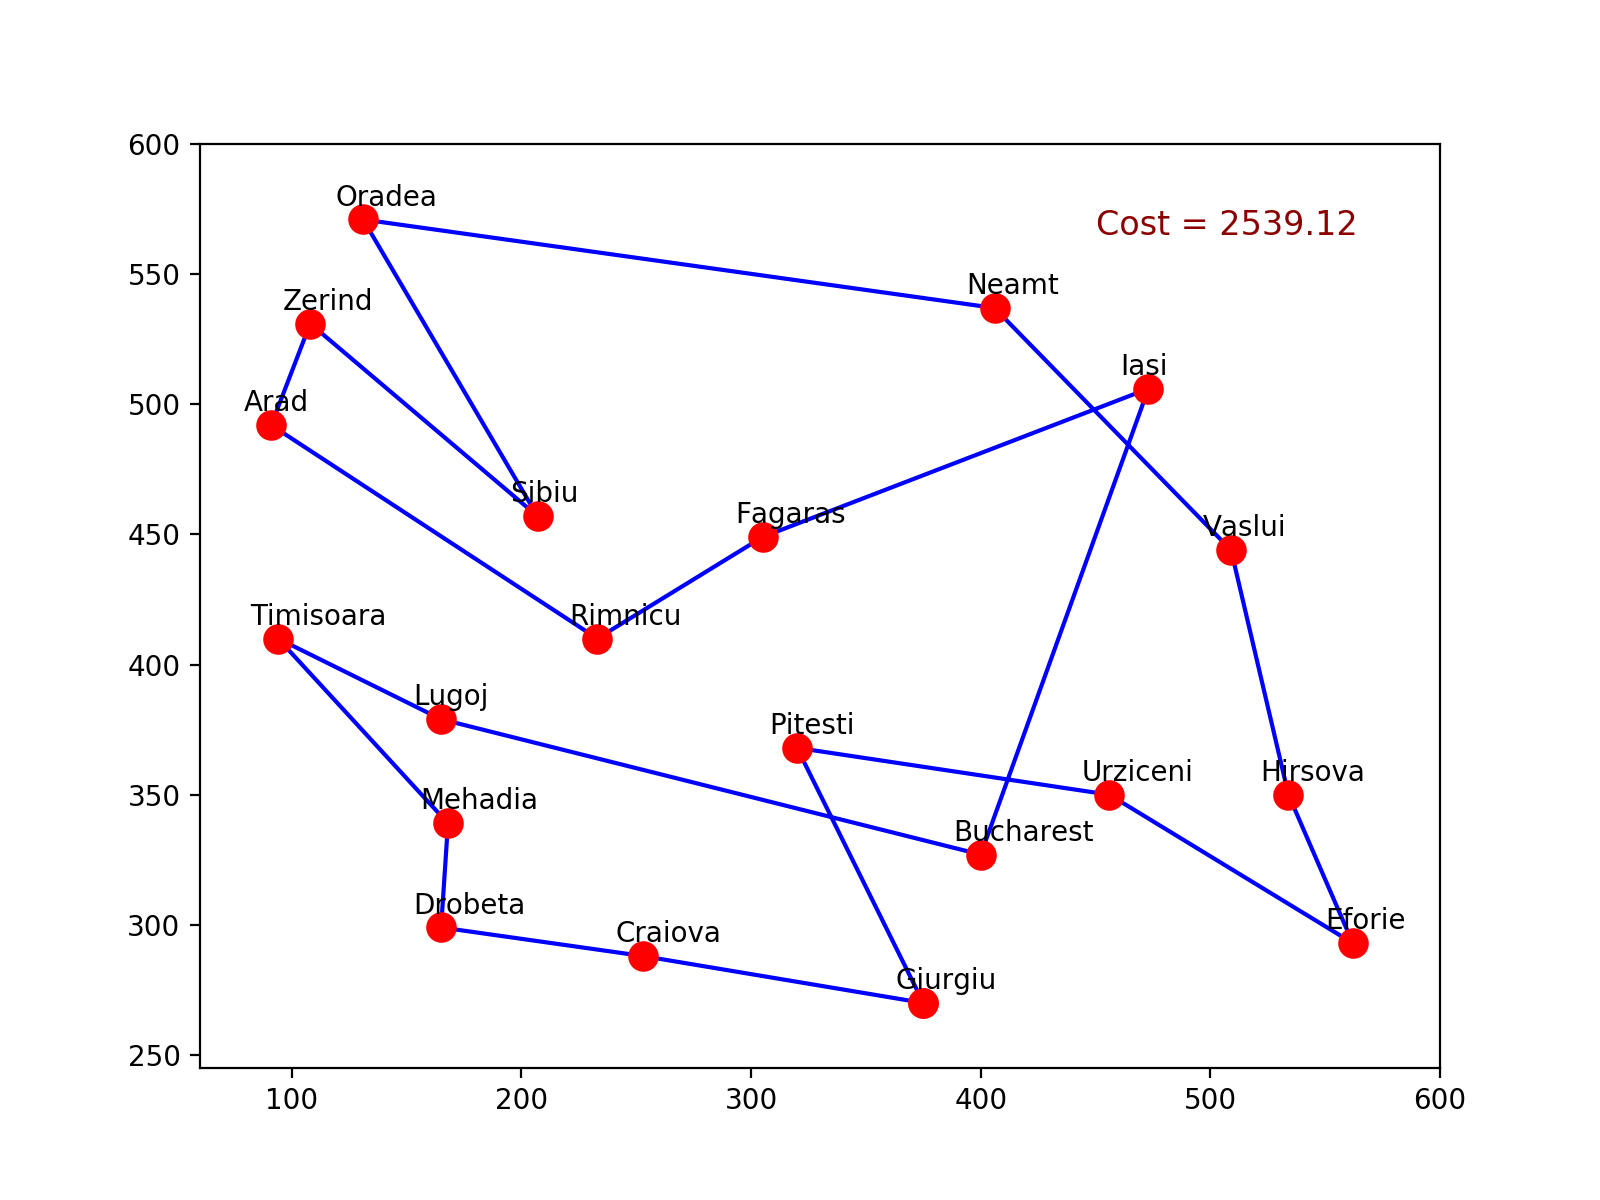

In [98]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

font = {'family': 'roboto',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

cities = []
distances ={}
states = []

# creating plotting area
fig = plt.figure(figsize = (8,6))
ax = plt.axes(xlim=(60, 600), ylim=(245, 600))
line, = ax.plot([], [], c="b",linewidth = 1.5, marker = 'o', markerfacecolor = 'r', markeredgecolor = 'r',markersize = 10)
text = ax.text(450, 565, "", fontdict = font)

# creating initial path
for name in romania_map.locations.keys():    
    distances[name] = {}
    cities.append(name)


# distances['city1']['city2'] contains euclidean distance between their coordinates
for name_1,coordinates_1 in romania_map.locations.items():
    for name_2,coordinates_2 in romania_map.locations.items():
        distances[name_1][name_2] = np.linalg.norm([coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])
        distances[name_2][name_1] = np.linalg.norm([coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])

# creating the problem        
tsp_problem = TSP_problem(cities)

# all the states as a 2-D list of paths
states = simulated_annealing_full(tsp_problem)

# calling the matplotlib animation function 
anim = animation.FuncAnimation(fig, animate, init_func = init,
                           frames = len(states), interval = len(states), blit = True, repeat = False)
plt.show()